In [ ]:
!pip install -U torchtext==0.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Dataset

In [ ]:
qa_dataset = [
    {
        "context": "Albert Einstein is very smart",
        "question": "Who is very smart",
        "answer": "Albert Einstein",
        "start_token": 0,
        "end_token": 1
    },
    {
        "context": "The forest cover over three thousand hectares",
        "question": "How much forest cover",
        "answer": "over three thousand hectares",
        "start_token": 3,
        "end_token": 6
    }
]

In [ ]:
for sample in qa_dataset:
    print(f"Context: {sample['context']}")
    print(f"Question: {sample['question']}")
    print(f"Answer: {sample['answer']} (Start: {sample['start_token']}, End: {sample['end_token']})")
    print("-" * 50)

Context: Albert Einstein is very smart
Question: Who is very smart
Answer: Albert Einstein (Start: 0, End: 1)
--------------------------------------------------
Context: The forest cover over three thousand hectares
Question: How much forest cover
Answer: over three thousand hectares (Start: 3, End: 6)
--------------------------------------------------


# Preprocesing

In [ ]:
from torchtext.data.utils import get_tokenizer
# Step 1: Tokenization
tokenizer = get_tokenizer("basic_english")

for sample in qa_dataset:
    sample["context_tokens"] = tokenizer(sample["context"])
    sample["question_tokens"] = tokenizer(sample["question"])

print("-" * 100)
for sample in qa_dataset:
    print(f"Context Tokens: {sample['context_tokens']}")
    print(f"Question Tokens: {sample['question_tokens']}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Context Tokens: ['albert', 'einstein', 'is', 'very', 'smart']
Question Tokens: ['who', 'is', 'very', 'smart']
----------------------------------------------------------------------------------------------------
Context Tokens: ['the', 'forest', 'cover', 'over', 'three', 'thousand', 'hectares']
Question Tokens: ['how', 'much', 'forest', 'cover']
----------------------------------------------------------------------------------------------------


In [ ]:
# Step 2: Build Vocabulary
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(dataset):
    for sample in dataset:
        yield sample["context_tokens"]
        yield sample["question_tokens"]

# Define vocab size
vocab_size = 12

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(qa_dataset),
                                  max_tokens=vocab_size,
                                  specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])  # Set unknown token index

# Print vocabulary mappings
print("Vocabulary Mapping:")
print(vocab.get_stoi())

Vocabulary Mapping:
{'much': 11, 'how': 10, 'albert': 7, 'hectares': 9, 'very': 6, 'smart': 5, 'is': 4, 'forest': 3, 'cover': 2, 'einstein': 8, '<pad>': 1, '<unk>': 0}


In [ ]:
# Step 3: Vectorization
def vectorize(tokens, vocab, sequence_length):
    token_ids = [vocab[token] for token in tokens][:sequence_length]
    token_ids += [vocab["<pad>"]] * (sequence_length - len(token_ids))  # Pad sequence
    return torch.tensor(token_ids, dtype=torch.long)

context_length = 5
question_length = 5

for sample in qa_dataset:
    sample["context_vector"] = vectorize(sample["context_tokens"], vocab, context_length)
    sample["question_vector"] = vectorize(sample["question_tokens"], vocab, question_length)
print("-" * 50)
for sample in qa_dataset:
    print(f"Context Vector: {sample['context_vector']}")
    print(f"Question Vector: {sample['question_vector']}")
    print("-" * 50)

--------------------------------------------------
Context Vector: tensor([7, 8, 4, 6, 5])
Question Vector: tensor([0, 4, 6, 5, 1])
--------------------------------------------------
Context Vector: tensor([0, 3, 2, 0, 0])
Question Vector: tensor([10, 11,  3,  2,  1])
--------------------------------------------------


# NLP model

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, question_length):
        super(SimpleMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten()

        input_dim = embedding_dim * (context_length + question_length)  # Combined input size
        self.fc_start = nn.Linear(input_dim, context_length)  # Start token scores
        self.fc_end = nn.Linear(input_dim, context_length)    # End token scores

    def forward(self, context, question):
        context_emb = self.embedding(context)  # (batch, context_len, emb_dim)
        question_emb = self.embedding(question)  # (batch, question_len, emb_dim)

        x = torch.cat([context_emb, question_emb], dim=1)  # Concatenate along token axis
        x = self.flatten(x)  # Flatten embeddings

        start_scores = self.fc_start(x)  # Predict start positions
        end_scores = self.fc_end(x)      # Predict end positions
        return start_scores, end_scores

In [ ]:
torch.manual_seed(42)
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, question_length):
        super(SimpleMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        print("🟢 Embedding:")
        print(self.embedding.weight)
        self.flatten = nn.Flatten()

        input_dim = embedding_dim * (context_length + question_length)  # Combined input size
        self.fc_start = nn.Linear(input_dim, context_length)  # Start token scores
        self.fc_end = nn.Linear(input_dim, context_length)    # End token scores
        print("🟢 FC Start:")
        print(self.fc_start.weight)
        print("🟢 FC Start Bias:")
        print(self.fc_start.bias)
        print("🟢 FC End:")
        print(self.fc_end.weight)
        print("🟢 FC End Bias:")
        print(self.fc_end.bias)

    def forward(self, context, question):
        print("🟢 Context:")
        print(context)
        print("🟠 Question:")
        print(question)

        context_emb = self.embedding(context)  # (batch, context_len, emb_dim)
        question_emb = self.embedding(question)  # (batch, question_len, emb_dim)

        print("🟢 Context Embedding:")
        print(context_emb)
        print("🟠 Question Embedding:")
        print(question_emb)

        x = torch.cat([question_emb, context_emb], dim=1)  # Concatenate along token axis
        print("🔵 Concatenated Embedding:")
        print(x)

        x = self.flatten(x)  # Flatten embeddings
        print("🟣 Flattened Input:")
        print(x)

        start_scores = self.fc_start(x)  # Predict start positions
        end_scores = self.fc_end(x)      # Predict end positions


        print("🔴 Start Scores:")
        print(start_scores)
        print("🔵 End Scores:")
        print(end_scores)


        return start_scores, end_scores

In [ ]:
embedding_dim = 2
model = SimpleMLP(vocab_size, embedding_dim, context_length, question_length)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

🟢 Embedding:
Parameter containing:
tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [ 0.3559, -0.6866],
        [-0.4934,  0.2415],
        [-1.1109,  0.0915],
        [-2.3169, -0.2168],
        [-0.3097, -0.3957],
        [ 0.8034, -0.6216],
        [-0.5920, -0.0631],
        [-0.8286,  0.3309]], requires_grad=True)
🟢 FC Start:
Parameter containing:
tensor([[ 0.0601, -0.0606,  0.0941,  0.1996,  0.1293, -0.0978,  0.1291,  0.0400,
          0.1136, -0.1363, -0.2214, -0.0864, -0.1715,  0.1835,  0.0644,  0.0926,
          0.0707, -0.0039,  0.1750, -0.1589],
        [ 0.0141, -0.1526,  0.0689, -0.0770,  0.0685, -0.0466,  0.1855, -0.1325,
         -0.1334, -0.1334,  0.2011,  0.0745,  0.2152, -0.1845, -0.2218, -0.1749,
         -0.1504,  0.0906,  0.0801,  0.1858],
        [-0.1155, -0.1524,  0.1186, -0.0904,  0.1357, -0.0531,  0.1279, -0.1737,
         -0.1128,  0.0682,  0.0473, -0.0570,  0.1333,  0.1520, -0.1622, -0.11

In [ ]:
# Convert labels (start & end) to tensor
def get_labels(sample):
    return torch.tensor([sample["start_token"], sample["end_token"]], dtype=torch.float32)

In [ ]:
for param in model.embedding.parameters():
    param.requires_grad = False

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    total_loss = 0
    for sample in qa_dataset:
        context_vector = sample["context_vector"].unsqueeze(0)  # Add batch dim
        question_vector = sample["question_vector"].unsqueeze(0)  # Add batch dim
        start_label, end_label = get_labels(sample)
        print(f"🔵 Start Label: {start_label}")
        print(f"🟣 End Label: {end_label}")

        optimizer.zero_grad()
        start_scores, end_scores = model(context_vector, question_vector)

        loss_start = loss_fn(start_scores.float(), start_label.unsqueeze(0).long())
        loss_end = loss_fn(end_scores.float(), end_label.unsqueeze(0).long())

        loss = loss_start + loss_end  # Combine both losses

        # loss.backward()
        # optimizer.step()

        total_loss += loss.item()

    if epoch == 0:
        print(f"📈 Epoch {epoch}, Loss: {total_loss:.4f}")

🔵 Start Label: 0.0
🟣 End Label: 1.0
🟢 Context:
tensor([[7, 8, 4, 6, 5]])
🟠 Question:
tensor([[0, 4, 6, 5, 1]])
🟢 Context Embedding:
tensor([[[-2.3169, -0.2168],
         [-0.3097, -0.3957],
         [ 0.3559, -0.6866],
         [-1.1109,  0.0915],
         [-0.4934,  0.2415]]])
🟠 Question Embedding:
tensor([[[ 1.9269,  1.4873],
         [ 0.3559, -0.6866],
         [-1.1109,  0.0915],
         [-0.4934,  0.2415],
         [ 0.9007, -2.1055]]])
🔵 Concatenated Embedding:
tensor([[[ 1.9269,  1.4873],
         [ 0.3559, -0.6866],
         [-1.1109,  0.0915],
         [-0.4934,  0.2415],
         [ 0.9007, -2.1055],
         [-2.3169, -0.2168],
         [-0.3097, -0.3957],
         [ 0.3559, -0.6866],
         [-1.1109,  0.0915],
         [-0.4934,  0.2415]]])
🟣 Flattened Input:
tensor([[ 1.9269,  1.4873,  0.3559, -0.6866, -1.1109,  0.0915, -0.4934,  0.2415,
          0.9007, -2.1055, -2.3169, -0.2168, -0.3097, -0.3957,  0.3559, -0.6866,
         -1.1109,  0.0915, -0.4934,  0.2415]])
🔴 Star

IndexError: Target 6 is out of bounds.

In [ ]:
import math
a = [ 0.4595, -0.6030, -1.1066, -0.5680,  0.0694]
b = [-0.1207,  0.0034,  1.0317, -1.4472,  0.9415]

rsa = []
rsb = []
for x in a:
    rsa.append(round(math.e**x, 4))
for x in b:
    rsb.append(round(math.e**x, 4))

print("a: " + str(rsa))
print(sum(rsa))
print("b: " + str(rsb))
print(sum(rsb))

softmaxa = []
softmaxb = []
for x in rsa:
    softmaxa.append(round(x/sum(rsa), 4))
for x in rsb:
    softmaxb.append(round(x/sum(rsb), 4))

print("a: " + str(softmaxa))
print("b: " + str(softmaxb))

a: [1.5833, 0.5472, 0.3307, 0.5667, 1.0719]
4.0998
b: [0.8863, 1.0034, 2.8058, 0.2352, 2.5638]
7.4945
a: [0.3862, 0.1335, 0.0807, 0.1382, 0.2615]
b: [0.1183, 0.1339, 0.3744, 0.0314, 0.3421]


# Illustrate

In [ ]:
def visualize_scores(context, question, model, vocab, context_length):
    """Visualize start and end token scores."""
    context_tokens = tokenizer(context)
    question_tokens = tokenizer(question)

    context_vector = vectorize(context_tokens, vocab, context_length).unsqueeze(0)
    question_vector = vectorize(question_tokens, vocab, question_length).unsqueeze(0)

    with torch.no_grad():
        start_scores, end_scores = model(context_vector, question_vector)
        start_scores = start_scores.squeeze().numpy()
        end_scores = end_scores.squeeze().numpy()

    token_labels = [f"{i}" for i in range(len(start_scores))]

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.bar(range(len(start_scores)), start_scores, color="blue", alpha=0.7)
    plt.xticks(range(len(start_scores)), token_labels, rotation=45, ha="right")
    plt.title("Start Token Scores")

    plt.subplot(2, 1, 2)
    plt.bar(range(len(end_scores)), end_scores, color="red", alpha=0.7)
    plt.xticks(range(len(end_scores)), token_labels, rotation=45, ha="right")
    plt.title("End Token Scores")

    plt.tight_layout()
    plt.show()

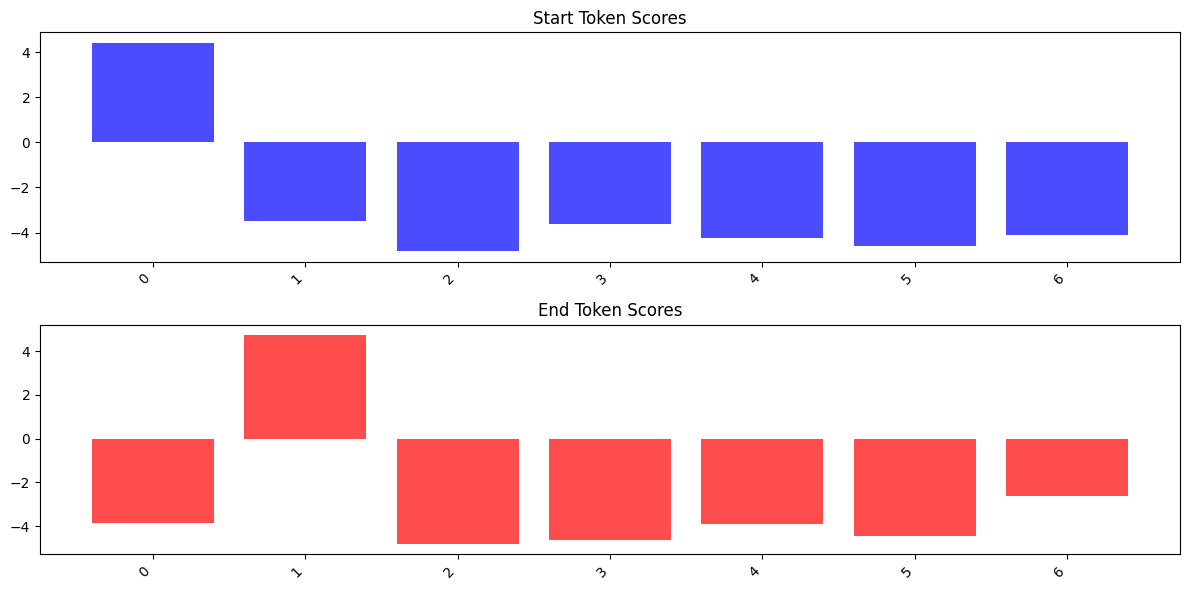

In [ ]:
context = qa_dataset[0]["context"]
question = qa_dataset[0]["question"]
visualize_scores(context, question, model, vocab, context_length)

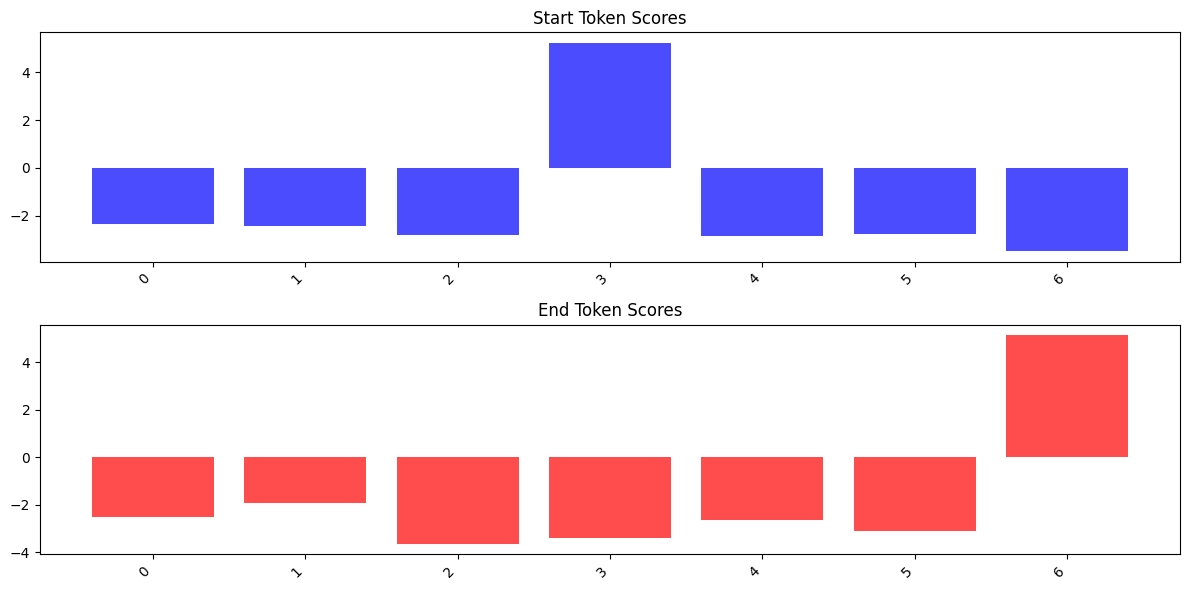

In [ ]:
context = qa_dataset[1]["context"]
question = qa_dataset[1]["question"]
visualize_scores(context, question, model, vocab, context_length)

In [ ]:
sample = qa_dataset[0]
context_vector = sample["context_vector"].unsqueeze(0)  # Add batch dimension
question_vector = sample["question_vector"].unsqueeze(0)  # Add batch dimension

In [ ]:
with torch.no_grad():
    print(f"\n Running Inference for Question: {sample['question']}\n")
    start_scores, end_scores = model(context_vector, question_vector)


 Running Inference for Question: Who is very smart?

🟢 Context Embedding:
tensor([[[ 0.8466, -1.4241],
         [-1.1002,  1.2863],
         [-1.4863,  0.3034],
         [-0.3233,  1.8174],
         [-0.7436, -1.1663],
         [-0.2292, -0.8918],
         [ 0.8830,  0.6806]]])
🟠 Question Embedding:
tensor([[[-0.0535, -1.5092],
         [-1.4863,  0.3034],
         [-0.3233,  1.8174],
         [-0.7436, -1.1663],
         [ 0.3303, -1.5258]]])
🔵 Concatenated Embedding:
tensor([[[ 0.8466, -1.4241],
         [-1.1002,  1.2863],
         [-1.4863,  0.3034],
         [-0.3233,  1.8174],
         [-0.7436, -1.1663],
         [-0.2292, -0.8918],
         [ 0.8830,  0.6806],
         [-0.0535, -1.5092],
         [-1.4863,  0.3034],
         [-0.3233,  1.8174],
         [-0.7436, -1.1663],
         [ 0.3303, -1.5258]]])
🟣 Flattened Input:
tensor([[ 0.8466, -1.4241, -1.1002,  1.2863, -1.4863,  0.3034, -0.3233,  1.8174,
         -0.7436, -1.1663, -0.2292, -0.8918,  0.8830,  0.6806, -0.0535, -1.

In [ ]:
predicted_start = torch.argmax(start_scores, dim=1).item()
predicted_end = torch.argmax(end_scores, dim=1).item()
print(f"Predicted Start Token Index: {predicted_start}")
print(f"Predicted End Token Index: {predicted_end}")

Predicted Start Token Index: 6
Predicted End Token Index: 4


In [ ]:
sample["context_tokens"]

['albert', 'einstein', 'is', 'very', 'smart', '.']

In [ ]:
predicted_answer_tokens = sample["context_tokens"][predicted_start : predicted_end + 1]
predicted_answer_tokens

[]

In [ ]:
predicted_answer = " ".join(predicted_answer_tokens)
predicted_answer

''

**The problem is how can we deal with the end_token < the start_token during training**